In [2]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.stats import gmean

In [3]:
a = 25 * special.zeta(5)/special.zeta(3)
np.sqrt(a)

4.643888037887359

2.68115000876075


' \n'

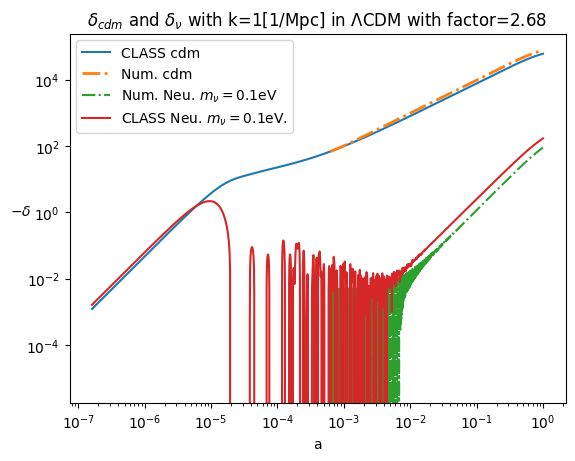

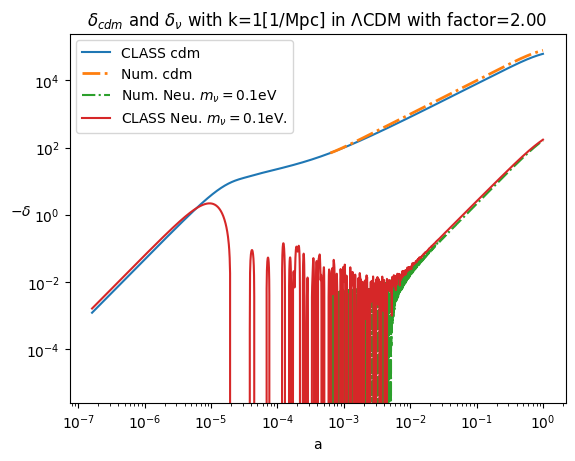

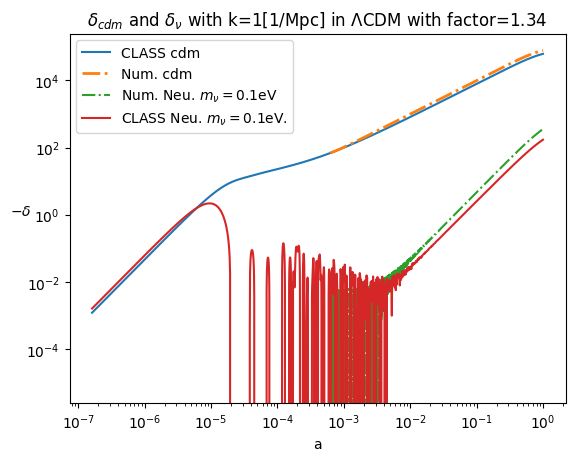

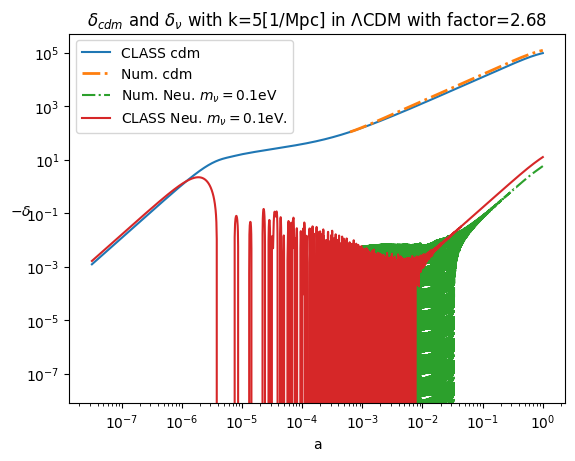

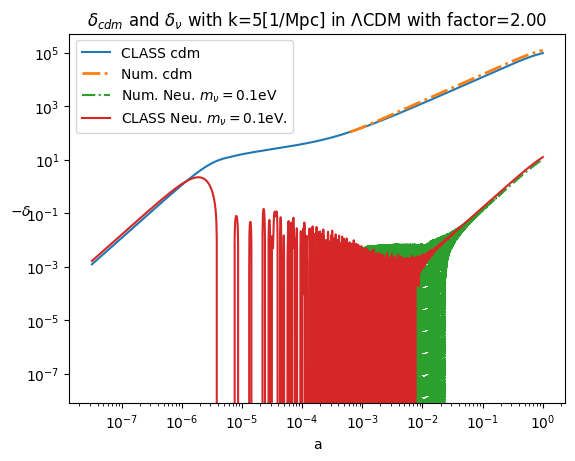

<Figure size 640x480 with 0 Axes>

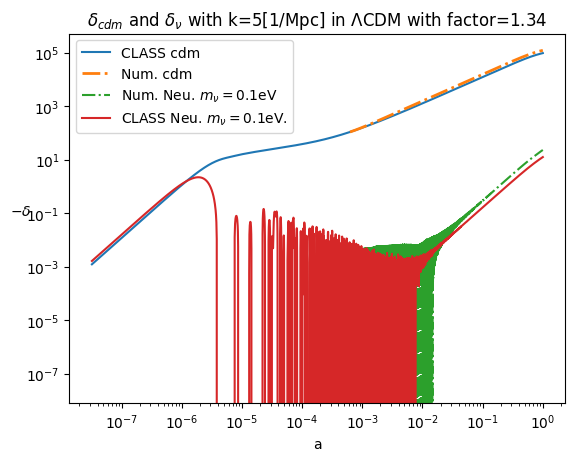

In [8]:
def f(k_ind=0,
    Omega_M = 0.31,
    Omega_b = 0.01,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = .4,
    a_end = 1,
      z=1600
     ):
    
    
    typ = "$\Lambda$CDM"
    
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    pb = pts[k_ind]
    a = pb["a"]
    cdm = pb["delta_cdm"]
    neutrino = pb["delta_ncdm[0]"]
    plt.figure(k_ind)#np.random.randint(1,1000))
    tau = pb["tau [Mpc]"]
    a_interp = scipy.interpolate.interp1d(tau,a)
    #z = 800
    a0 = 1/(z+1)
    delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])
    
    
    a_interp = scipy.interpolate.interp1d(a,tau)
    tau_interp = scipy.interpolate.interp1d(tau,a)
    
    
    
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    tau_class =  pts[k_ind]["tau [Mpc]"]
    
    delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #delta_cdm =  scipy.interpolate.interp1d(a_class,delta_class)
    tau_interp = scipy.interpolate.interp1d(a_class,tau_class)
    
    
    def H(a,om=Omega_M,ol=Omega_lambda):
        return H0 * np.sqrt(om / a + ol* a**2)
    
    def cdm_func(a,y):
        delta = y[0]
        theta = y[1]   
        d_delta   = - theta / (a * H(a))
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   = ( - nabla2phi -  H(a) * theta ) / (a*H(a))
        return [d_delta,d_theta]
    h = 1.1 
    y01 = [delta_interp(a0),5e-3]  #theta_interp(a0)]
    
    
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a):
        return factor * Tv(a) / mv

    
    
    def func(a,y):
        delta = y[0]
        d_delta = y[1]
        d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
        return [d_delta,d2_delta]
    
    
    def func1(a,y,k):
        delta = y[0]
        d_delta = y[1]
        
        delta_nu = y[2]
        d_delta_nu = y[3]
        
        d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
        
        d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu
        
        
        return [d_delta,d2_delta,d_delta_nu,d2_delta_nu]
    
    
    h = 0.00001
    #diff = (delta_interp(a0+h)-delta_interp(a0))/h
    
    diff = (delta_interp(a0+h/2)-delta_interp(a0-h/2))/h
    
    diff_neu =  (delta_interp_neu(a0+h/2)-delta_interp_neu(a0-h/2))/h
    y0 = [delta_interp(a0), diff,delta_interp_neu(a0),diff_neu]# diff]
    
    
    
    a_span = [a0,a_end]
    sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(k,))#,t_eval=np.logspace(np.log10(a0),0,100))
    t_sol = sol.t
    delta_sol = sol.y[0]
    
    
    plt.figure(np.random.randint(1,100000))
    
    plt.loglog(a_class,-cdm,label="CLASS cdm")
    plt.loglog(t_sol,-delta_sol,"-.",lw=2,label="Num. cdm ")
    
    
    delta_neu_sol = sol.y[2]
    plt.loglog(t_sol,-delta_neu_sol,"-.",label=r"Num. Neu. $m_{\nu}=$%seV " % (mv_test))
    plt.loglog(a_class,-delta_neutrino_class,label=r"CLASS Neu. $m_{\nu}=$%seV."%mv_test)
    
    plt.ylabel("$-\delta$",rotation=0)
    #plt.xlim([2e-8,1])
    #print(a0)
    plt.legend()
    plt.title(r"$\delta_{cdm}$ and $\delta_{\nu}$ with k=%s[1/Mpc] in %s with factor=%.2f"%(k,typ,factor))# using a cs-factor = %.2ffactor
    plt.xlabel("a")
    
    savtyp = "lambdacdm"
    if Omega_M >= 0.93:
        savtyp = "EdS"
    plt.savefig("num-neutrino-versus-class with k=%s %s %.2f mv=%.1f cs=%.2f num-cdm-source.pdf"% (kvec[k_ind],savtyp,factor,mv_test,factor))
    
    cosmo.struct_cleanup()
    return None

#f(0)
#f(1)
#f(2)
fact =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)) 
print(fact)
"""f(Omega_M = 0.31)
f(Omega_M = 0.98)

f(Omega_M = 0.31,kvec=[0.1])
f(Omega_M = 0.98,kvec=[0.1])

f(Omega_M = 0.31,kvec=[10])
f(Omega_M = 0.98,kvec=[10])

f(Omega_M = 0.31,kvec=[0.01])
f(Omega_M = 0.98,kvec=[0.01])



f(Omega_M = 0.31,factor=fact/2)
f(Omega_M = 0.98,factor=fact/2)

f(Omega_M = 0.31,kvec=[0.1],factor=fact/2)
f(Omega_M = 0.98,kvec=[0.1],factor=fact/2)

f(Omega_M = 0.31,kvec=[10],factor=fact/2)
f(Omega_M = 0.98,kvec=[10],factor=fact/2)

f(Omega_M = 0.31,kvec=[0.01],factor=fact/2)
f(Omega_M = 0.98,kvec=[0.01],factor=fact/2)


"""
"""
f(kvec=[1],factor=fact)
f(kvec=[1],factor=2)
f(kvec=[1],factor=fact/2)

f(kvec=[5],factor=fact)
f(kvec=[5],factor=2)
f(kvec=[5],factor=fact/2)
"""

f(kvec=[1],factor=fact,mv_test=0.1)
f(kvec=[1],factor=2,mv_test=0.1)
f(kvec=[1],factor=fact/2,mv_test=0.1)

f(kvec=[5],factor=fact,mv_test=0.1)
f(kvec=[5],factor=2,mv_test=0.1)
f(kvec=[5],factor=fact/2,mv_test=0.1)

#f(kvec=[5],factor=2)

""" 
"""

#f(Omega_M = 0.98, kvec=[2])

#f(4)




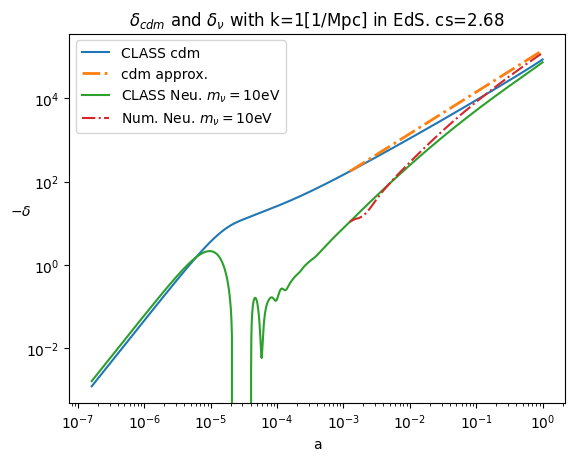

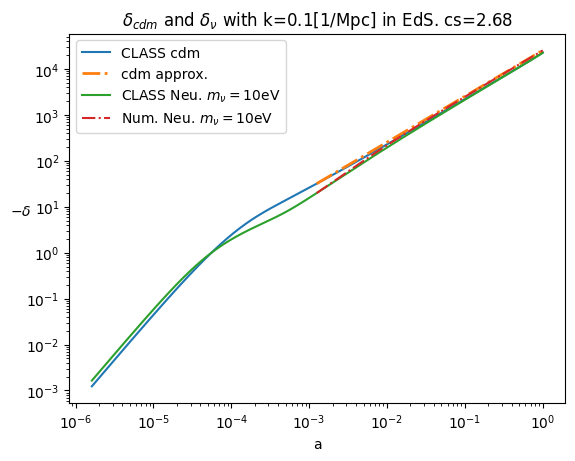

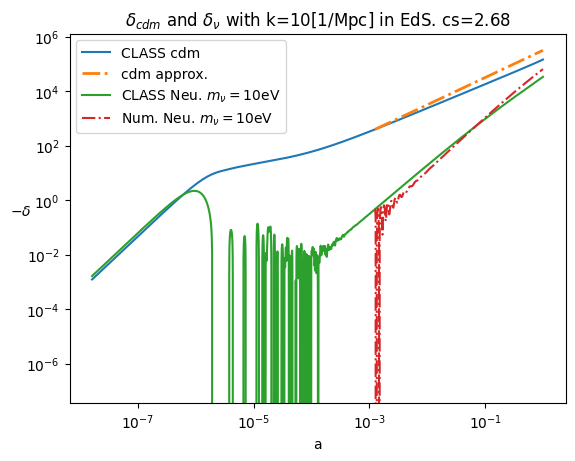

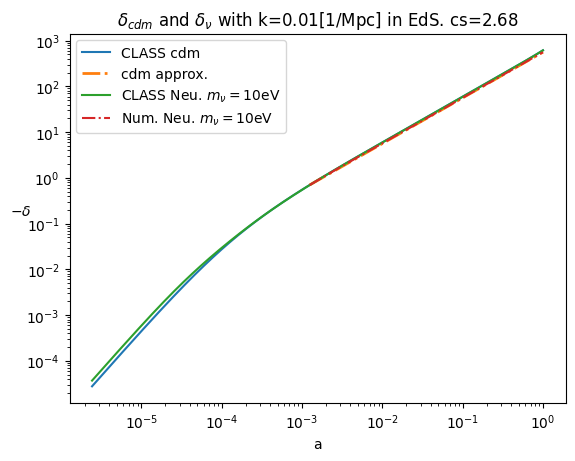

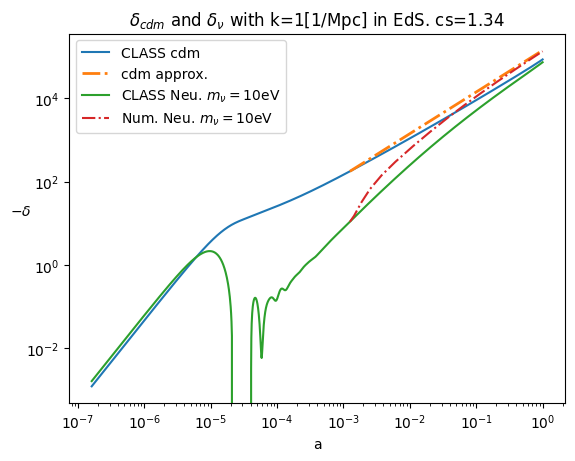

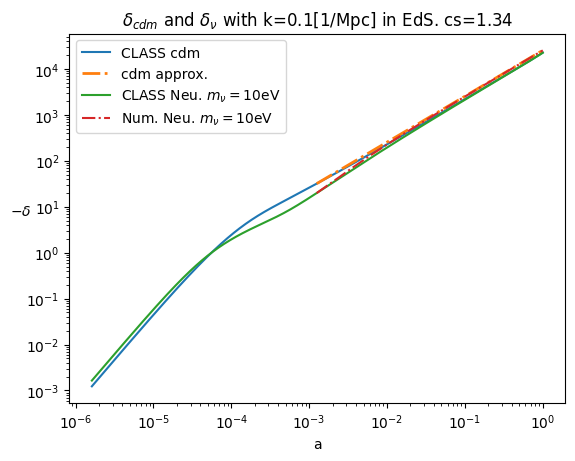

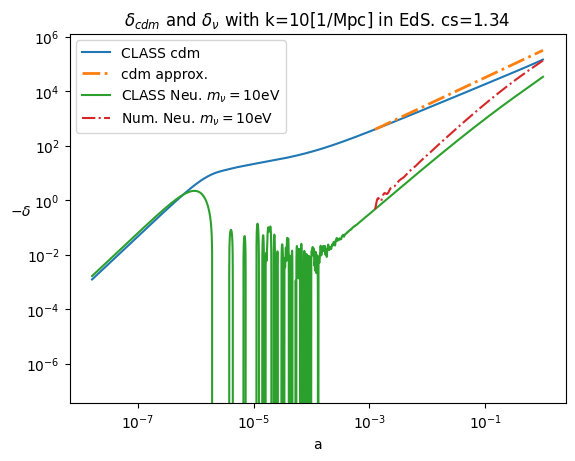

<Figure size 640x480 with 0 Axes>

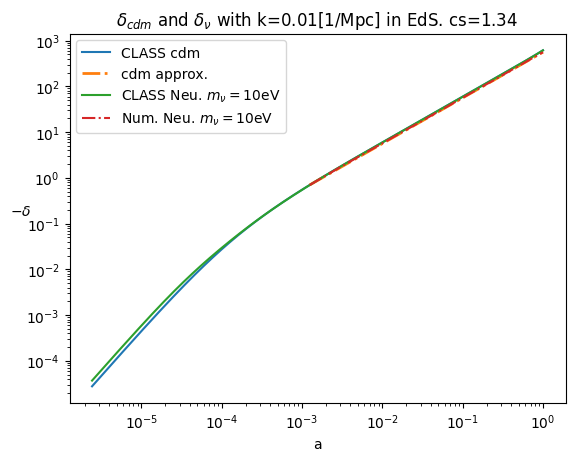

In [13]:
# i f1 sourcer man fra en approximation af cdm.

def f1(k_ind=0,
    Omega_M = 0.31,
    Omega_b = 0.01,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = 10,
    a_end = 1,
    z = 800
     ):
    
    
    typ = "$\Lambda$CDM"
    
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    pb = pts[k_ind]
    a = pb["a"]
    cdm = pb["delta_cdm"]
    neutrino = pb["delta_ncdm[0]"]
    plt.figure(k_ind)#np.random.randint(1,1000))
    tau = pb["tau [Mpc]"]
    a_interp = scipy.interpolate.interp1d(tau,a)
    
    a0 = 1/(z+1)
    delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])
    
    
    a_interp = scipy.interpolate.interp1d(a,tau)
    tau_interp = scipy.interpolate.interp1d(tau,a)
    
    
    
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    tau_class =  pts[k_ind]["tau [Mpc]"]
    
    delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #delta_cdm =  scipy.interpolate.interp1d(a_class,delta_class)
    tau_interp = scipy.interpolate.interp1d(a_class,tau_class)
    
    
    delta0 = delta_interp(a0)
    
    def H(a,om=Omega_M,ol=Omega_lambda):
        return H0 * np.sqrt(om / a + ol* a**2)
    
    def cdm_func(a,y):
        delta = y[0]
        theta = y[1]   
        d_delta   = - theta / (a * H(a))
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   = ( - nabla2phi -  H(a) * theta ) / (a*H(a))
        return [d_delta,d_theta]
    h = 1.1 
    y01 = [delta_interp(a0),5e-3]  #theta_interp(a0)]
    
    
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a):
        return factor * Tv(a) / mv

    
    
    def func(a,y):
        delta = y[0]
        d_delta = y[1]
        d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
        return [d_delta,d2_delta]
    
    
    def func1(a,y,k):
        delta = a * delta0/a0
        #d_delta = y[1]
        
        delta_nu = y[0]
        d_delta_nu = y[1]
        
        #d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
        
        d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu
        
        
        return [d_delta_nu,d2_delta_nu]
    
    
    h = 0.00001
    #diff = (delta_interp(a0+h)-delta_interp(a0))/h
    
    diff = (delta_interp(a0+h/2)-delta_interp(a0-h/2))/h
    
    diff_neu =  (delta_interp_neu(a0+h/2)-delta_interp_neu(a0-h/2))/h
    y0 = [delta_interp_neu(a0),diff_neu]# diff]
    
    
    
    a_span = [a0,a_end]
    sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(k,))#,t_eval=np.logspace(np.log10(a0),0,100))
    t_sol = sol.t
    #delta_sol = sol.y[0]
    
    
    plt.figure(np.random.randint(1,100000))
    
    plt.loglog(a_class,-cdm,label="CLASS cdm")
    #plt.loglog(t_sol,-delta_sol,"-.",lw=2,label=r"Num. cdm  $m_{\nu}=$%seV."%mv_test)
    
    
    delta_neu_sol = sol.y[0]
    plt.loglog(t_sol, - t_sol * delta0/a0,"-.",lw=2,label="cdm approx.")
    plt.loglog(a_class,-delta_neutrino_class,label=r"CLASS Neu. $m_{\nu}=$%seV " % (mv_test))
    plt.loglog(t_sol,-delta_neu_sol,"-.",label=r"Num. Neu. $m_{\nu}=$%seV " % (mv_test))
    
    
    plt.ylabel("$-\delta$",rotation=0)
    #plt.xlim([2e-8,1])
    #print(a0)
    plt.legend()
    plt.title(r"$\delta_{cdm}$ and $\delta_{\nu}$ with k=%s[1/Mpc] in %s cs=%.2f"%(k,typ,factor)) #using a cs-factor = %.2ffactor
    plt.xlabel("a")
    
    savtyp = "lambdacdm"
    if Omega_M >= 0.93:
        savtyp = "EdS"
    plt.savefig("num-neutrino-versus-class-with-k=%s-%s-%.4f-mv=%.1f-approx-cdm-source.pdf"% (kvec[k_ind],savtyp,factor,mv_test))
    
    cosmo.struct_cleanup()
    return None
"""f1(Omega_M = 0.98,kvec = list(0.67*np.logspace(-4,np.log10(3),10)),k_ind=-1)

f1(Omega_M = 0.31)#,z=2000)
f1(Omega_M = 0.98)#,z=2000)

f1(Omega_M = 0.31,kvec=[0.1])
f1(Omega_M = 0.98,kvec=[0.1])

f1(Omega_M = 0.31,kvec=[10])
f1(Omega_M = 0.98,kvec=[10])

f1(Omega_M = 0.31,kvec=[0.01])
f1(Omega_M = 0.98,kvec=[0.01])
"""

#f1(Omega_M = 0.31)
f1(Omega_M = 0.98)

#f1(Omega_M = 0.31,kvec=[0.1])
f1(Omega_M = 0.98,kvec=[0.1])

#f1(Omega_M = 0.31,kvec=[10])
f1(Omega_M = 0.98,kvec=[10])

#f1(Omega_M = 0.31,kvec=[0.01])
f1(Omega_M = 0.98,kvec=[0.01])



#f1(Omega_M = 0.31,factor=fact/2)
f1(Omega_M = 0.98,factor=fact/2)

#f1(Omega_M = 0.31,kvec=[0.1],factor=fact/2)
f1(Omega_M = 0.98,kvec=[0.1],factor=fact/2)

#f1(Omega_M = 0.31,kvec=[10],factor=fact/2)
f1(Omega_M = 0.98,kvec=[10],factor=fact/2)

#f1(Omega_M = 0.31,kvec=[0.01],factor=fact/2)
f1(Omega_M = 0.98,kvec=[0.01],factor=fact/2)


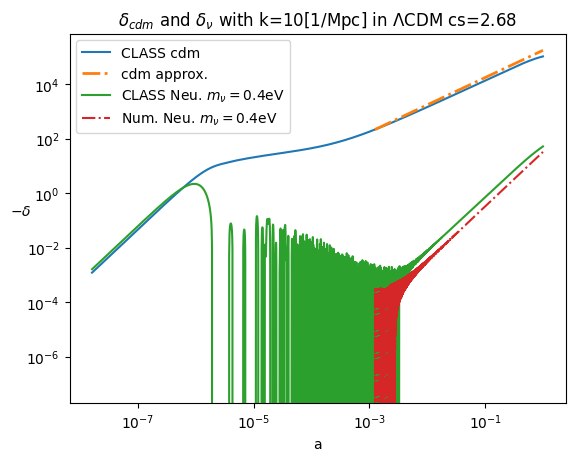

<Figure size 640x480 with 0 Axes>

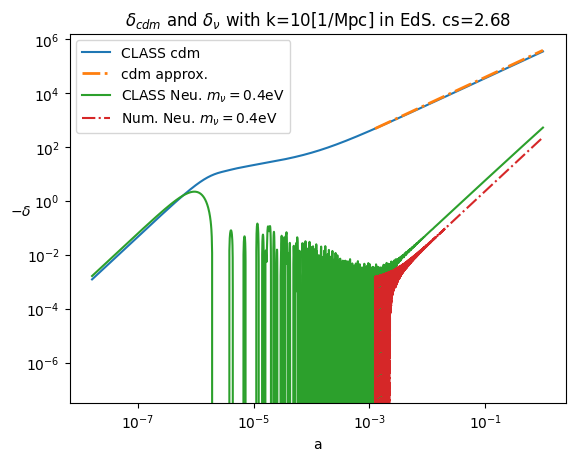

In [11]:
f1(Omega_M = 0.31,kvec=[10])
f1(Omega_M = 0.98,kvec=[10])


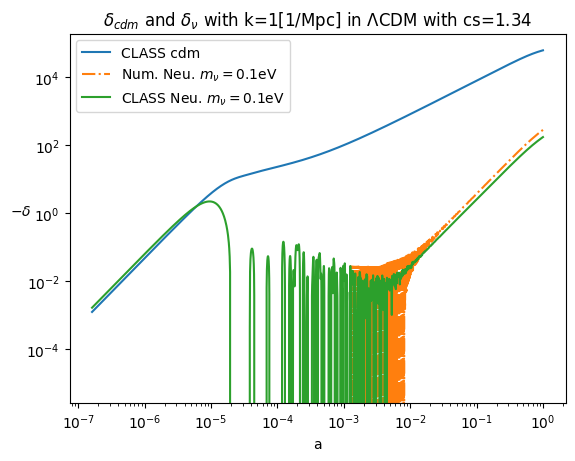

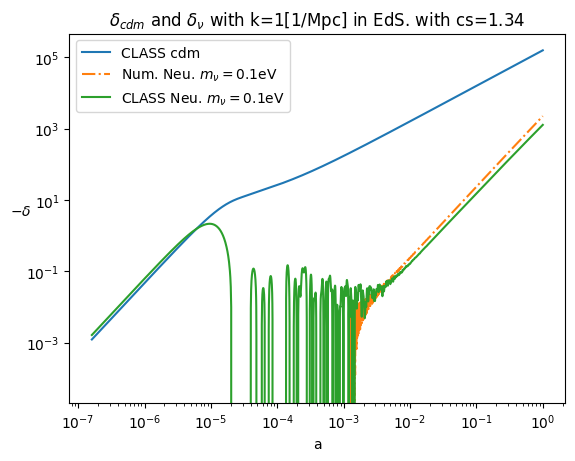

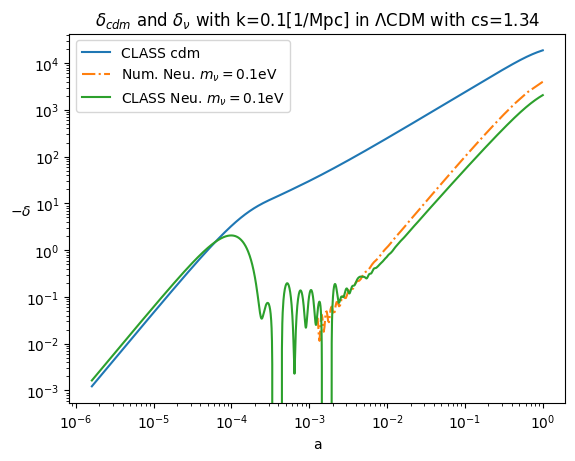

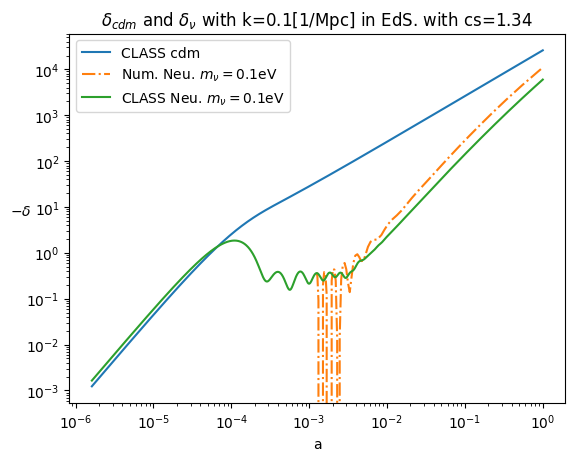

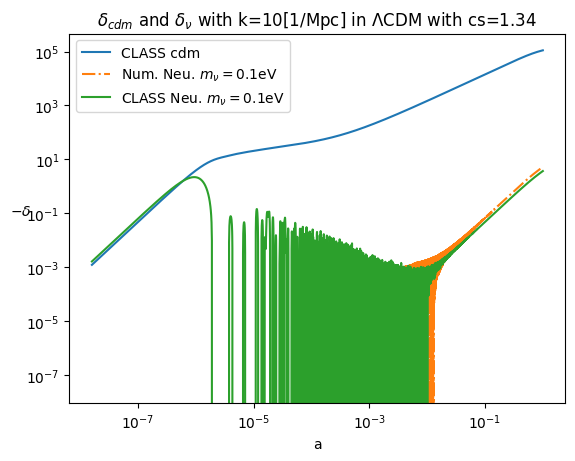

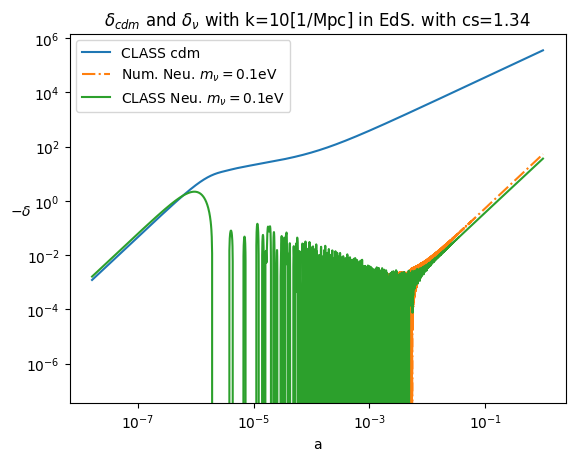

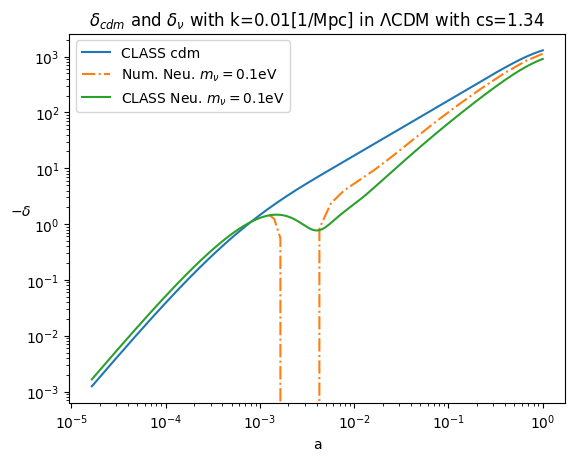

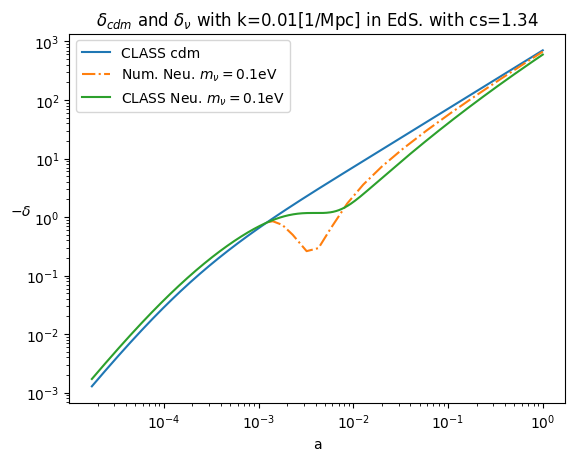

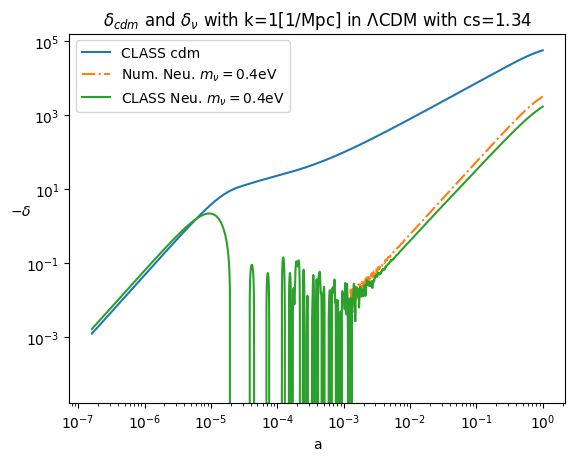

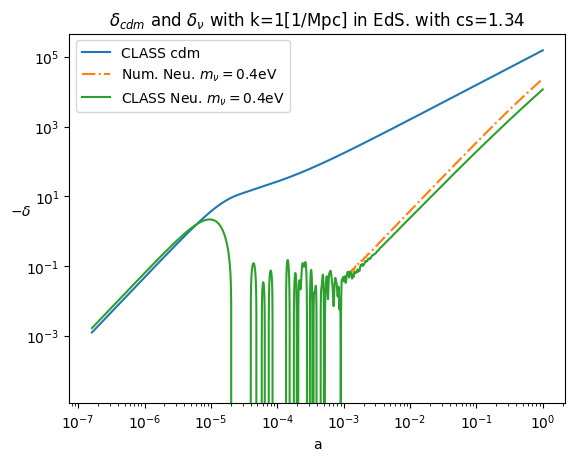

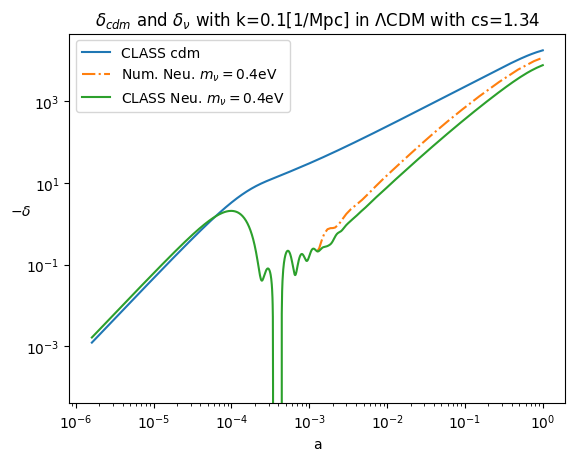

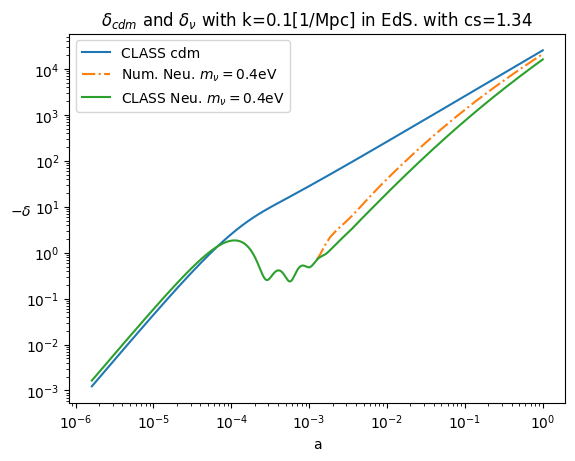

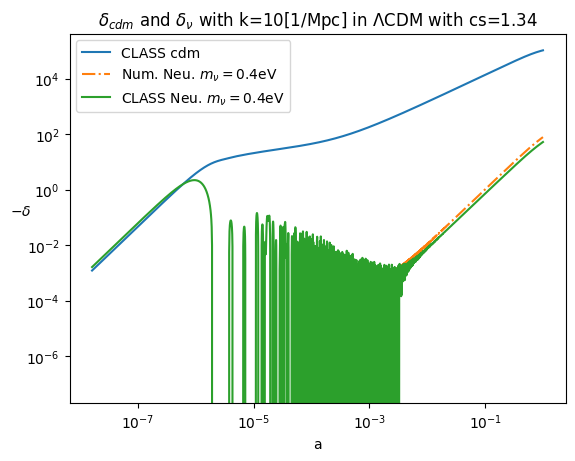

In [ ]:
def f2(k_ind=0,
    Omega_M = 0.31,
    Omega_b = 0.01,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = .1,
    a_end = 1,
    z = 800
     ):
    
    
    typ = "$\Lambda$CDM"
    
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    pb = pts[k_ind]
    a = pb["a"]
    cdm = pb["delta_cdm"]
    neutrino = pb["delta_ncdm[0]"]
    plt.figure(k_ind)#np.random.randint(1,1000))
    tau = pb["tau [Mpc]"]
    a_interp = scipy.interpolate.interp1d(tau,a)
    
    a0 = 1/(z+1)
    delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])
    
    
    a_interp = scipy.interpolate.interp1d(a,tau)
    tau_interp = scipy.interpolate.interp1d(tau,a)
    
    
    
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    tau_class =  pts[k_ind]["tau [Mpc]"]
    
    delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #delta_cdm =  scipy.interpolate.interp1d(a_class,delta_class)
    tau_interp = scipy.interpolate.interp1d(a_class,tau_class)
    
    
    delta0 = delta_interp(a0)
    
    def H(a,om=Omega_M,ol=Omega_lambda):
        return H0 * np.sqrt(om / a + ol* a**2)
    
    def cdm_func(a,y):
        delta = y[0]
        theta = y[1]   
        d_delta   = - theta / (a * H(a))
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   = ( - nabla2phi -  H(a) * theta ) / (a*H(a))
        return [d_delta,d_theta]
    h = 1.1 
    y01 = [delta_interp(a0),5e-3]  #theta_interp(a0)]
    
    
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a):
        return factor * Tv(a) / mv

    
    
    def func(a,y):
        delta = y[0]
        d_delta = y[1]
        d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
        return [d_delta,d2_delta]
    
    
    def func1(a,y,k):
        #delta = a * delta0/a0
        #d_delta = y[1]
        delta = delta_interp(a)
        delta_nu = y[0]
        d_delta_nu = y[1]
        
        #d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
        
        d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu
        
        
        return [d_delta_nu,d2_delta_nu]
    
    
    h = 0.00001
    #diff = (delta_interp(a0+h)-delta_interp(a0))/h
    
    diff = (delta_interp(a0+h/2)-delta_interp(a0-h/2))/h
    
    diff_neu =  (delta_interp_neu(a0+h/2)-delta_interp_neu(a0-h/2))/h
    y0 = [delta_interp_neu(a0),diff_neu]# diff]
    
    
    
    a_span = [a0,a_end]
    sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(k,))#,t_eval=np.logspace(np.log10(a0),0,100))
    t_sol = sol.t
    #delta_sol = sol.y[0]
    
    
    plt.figure(np.random.randint(1,100000))
    
    plt.loglog(a_class,-cdm,label="CLASS cdm")
    #plt.loglog(t_sol,-delta_sol,"-.",lw=2,label=r"Num. cdm  $m_{\nu}=$%seV."%mv_test)
    
    
    delta_neu_sol = sol.y[0]
    #plt.loglog(t_sol, - t_sol * delta0/a0,"-.",lw=2,label="cdm approx.")
    plt.loglog(t_sol,-delta_neu_sol,"-.",label=r"Num. Neu. $m_{\nu}=$%seV " % (mv_test))
    plt.loglog(a_class,-delta_neutrino_class,label=r"CLASS Neu. $m_{\nu}=$%seV " % (mv_test))
    
    plt.ylabel("$-\delta$",rotation=0)
    #plt.xlim([2e-8,1])
    #print(a0)
    plt.legend()
    plt.title(r"$\delta_{cdm}$ and $\delta_{\nu}$ with k=%s[1/Mpc] in %s with cs=%.2f"%(k,typ,factor))#using a cs-factor = %.2f,factor
    plt.xlabel("a")
    
    savtyp = "lambdacdm"
    if Omega_M >= 0.93:
        savtyp = "EdS"
    plt.savefig("num-neutrino-versus-class with k=%s %s %.4f mv=%.1f CLASS-cdm-source.pdf"% (kvec[k_ind],savtyp,factor,mv_test))
    
    cosmo.struct_cleanup()
    return None


f2(Omega_M = 0.31)#,z=2000)
f2(Omega_M = 0.98)#,z=2000)

f2(Omega_M = 0.31,kvec=[0.1])
f2(Omega_M = 0.98,kvec=[0.1])

f2(Omega_M = 0.31,kvec=[10])
f2(Omega_M = 0.98,kvec=[10])

f2(Omega_M = 0.31,kvec=[0.01])
f2(Omega_M = 0.98,kvec=[0.01])

f2(Omega_M = 0.31,mv_test = .4)
f2(Omega_M = 0.98,mv_test = .4)

f2(Omega_M = 0.31,kvec=[0.1],mv_test = .4)
f2(Omega_M = 0.98,kvec=[0.1],mv_test = .4)

f2(Omega_M = 0.31,kvec=[10],mv_test = .4)
f2(Omega_M = 0.98,kvec=[10],mv_test = .4)

f2(Omega_M = 0.31,kvec=[0.01],mv_test = .4)
f2(Omega_M = 0.98,kvec=[0.01],mv_test = .4)


## Alt herefter er ikke relevant


<Figure size 640x480 with 0 Axes>

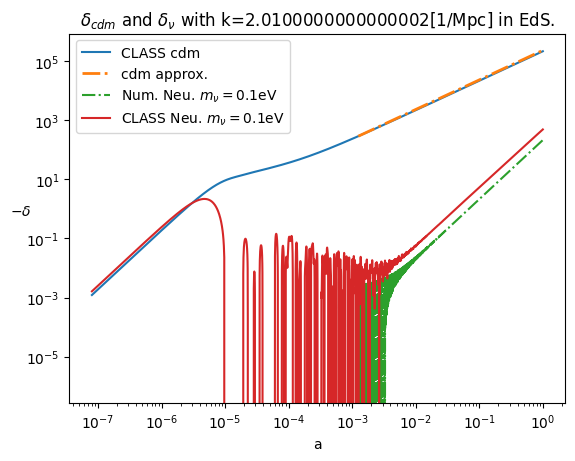

In [22]:

f1(Omega_M = 0.98,kvec = list(0.67*np.logspace(-4,np.log10(3),10)),k_ind=-1)